# 使用指南——短链核酸的快速聚类

使用包的`SeqList`类，可以直接从原始测序`.fastq`文件中读取所有序列，并根据不同的相似度度量，构建核酸序列在向量空间中的嵌入，再进行聚类，将核酸序列分成多个Family。还可以根据聚类的结果，自动绘制图片，并保存为`.svg`，`.pdf`或`.png`等格式，图片不仅可以显示每个类中的核酸序列，还能以不同的色彩高亮显示每类的特征kmer片段，用加粗显示单链核酸的未配对片段（在aptamer中，发挥结合作用的往往是未配对的loop区域）。

## 读取测序文件

安装后，导入`SeqList`类。

In [3]:
from aptamerutils import SeqList

从`.fastq`文件中读取需要分析的序列。可选从单个`.fastq`文件中读取，或读取一个文件夹下所有扩展名为`.fastq`的文件。

In [4]:
seq = SeqList().fromfastq("../example/example.fastq")

In [9]:
seq = SeqList().fromfastqFolder("../example")

## 序列预处理
如果需要，可以删除原始序列5'端和3'端的无关部分，只保留关键序列。模块提供了两种对序列进行trimming的方式：

（1）可以给定有效序列**5'端和3'端外侧的固定序列**，只保留它们之间的序列，不含有这两个给定序列的原始序列将被删除；也可以限制有效序列的长度，不符合这个长度的序列也将被删除；

（2）给定有效序列**5'端上游的固定序列，并给定有效序列的长度**，程序在发现该固定序列后将截取其后给定长度的一段作为有效序列。

以上两种处理方式二选一即可，不要循环调用。

In [8]:
seq = seq.trimTwoEnds("GACGAC", "GTCGTC")

In [10]:
seq = seq.trimTwoEndsWithLength("GACGAC", 30)

## 序列的聚类
得到有效序列后，为了对它们进行聚类，需要找到合适的距离度量，并计算序列两两之间的距离大小，再用距离信息重构它们在向量空间中嵌入的坐标，最后用传统的聚类方法，即可用纯数学的方法，找到文本间的相似关系。使用此模块，可以用三步解决：

（1）使用`generateDistMap`，构造距离矩阵。有三种距离可选，**编辑距离，压缩距离和kmer集合的Jaccard距离**。为了找出aptamer同一家族具有的明显特征，一般推荐使用kmer集合的Jaccard距离（默认选项）。编辑距离计算快，也可考虑用于粗略分类。

（2）使用`createPosMap`，用距离矩阵重构空间坐标，得到序列在向量空间中的嵌入。可用**UMAP**（默认选项）或**MDS**方法，UMAP只考虑局部流形结构；MDS则是全局重构，计算量极大。序列较多时，不建议使用MDS方法。

（3）使用`getCluster`，得到每个序列的类别标签。聚类方法可选用**K-means或DBSCAN**。一般建议使用DBSCAN（默认选项），它是基于密度聚类的方法，自动选择类别的数量、并筛选噪声点。K-means需要人为指定聚类数量，不好掌控，除非你想给每个序列都打上类别标签。如需调整聚类效果，可指定`eps = 0.8`或`n_clusters = 8`等来调整聚类参数。

In [11]:
clusters = seq.generateDistMap().createPosMap().getCluster(eps = 0.6)

100%|██████████| 2053351/2053351 [00:30<00:00, 67497.43it/s]
c:\Users\31885\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


UMAP(metric='precomputed', n_components=20, n_neighbors=50, verbose=True)
Mon Aug  4 18:11:29 2025 Construct fuzzy simplicial set
Mon Aug  4 18:11:29 2025 Finding Nearest Neighbors
Mon Aug  4 18:11:35 2025 Finished Nearest Neighbor Search
Mon Aug  4 18:11:39 2025 Construct embedding


Epochs completed:  20%| █▉         99/500 [00:02]

	completed  0  /  500 epochs
	completed  50  /  500 epochs


Epochs completed:  38%| ███▊       188/500 [00:02]

	completed  100  /  500 epochs
	completed  150  /  500 epochs


Epochs completed:  60%| █████▉     298/500 [00:03]

	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs


Epochs completed:  81%| ████████   405/500 [00:03]

	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:03]


Mon Aug  4 18:11:42 2025 Finished embedding


然后把类别标签回传给先前定义的`SeqList`类，以便进行下一步操作。

In [12]:
seq.getClustersLabeled(clusters)

{Sequence("GGGAACTTTTACCCCATGGTGGTCGGGCTT"): {'Count': 1, 'label': {'cluster': 0, 'filelabel': 'example.fastq'}}, Sequence("GGGAAGCTGTACCGCATGGTGGTGGGGGTT"): {'Count': 11, 'label': {'cluster': 0, 'filelabel': 'example.fastq'}}, Sequence("ATAGCGGTTCCTATGGAGTAGGGTGGAGTT"): {'Count': 43, 'label': {'cluster': 1, 'filelabel': 'example.fastq'}}, Sequence("GGGAATCTGTACCGGATGGTGGCGGGGTTT"): {'Count': 2, 'label': {'cluster': 2, 'filelabel': 'example.fastq'}}, Sequence("GCCGGTAACAAGTGATTTGGTCTCTGGTGA"): {'Count': 1, 'label': {'cluster': -1, 'filelabel': 'example.fastq'}}, Sequence("GGGAAGCTGTACCGGATGGTGGGGGGGGTT"): {'Count': 15, 'label': {'cluster': 2, 'filelabel': 'example.fastq'}}, Sequence("ATAGCGGTTCCTATGCAGTAGGGGGGAGTT"): {'Count': 1, 'label': {'cluster': 1, 'filelabel': 'example.fastq'}}, Sequence("TGGAAGGTTCCTGCCGGTTAGGAGGGTGTA"): {'Count': 4, 'label': {'cluster': 3, 'filelabel': 'example.fastq'}}, Sequence("GGGAAGCTGTACCCGATGGTGGTGGGGGTT"): {'Count': 9, 'label': {'cluster': 0, 'filelabel

如果你希望拿出reads数最高的前k条序列展示，那么应该先按照reads数排序，并取前k条；再把这些前k条序列按照类别标签整理出来。

In [13]:
seq_sorted = seq.sortbyCount(topk = 50)
seq_sorted = seq_sorted.sortbyCluster()
print(seq_sorted)

{Sequence("GGGAATCTGTACCTTATGGTGGTGGGGTTT"): {'Count': 5058, 'label': {'cluster': 0, 'filelabel': 'example.fastq'}}, Sequence("GGGAATCTGTACCTTATNGTGGTGGGGTTT"): {'Count': 123, 'label': {'cluster': 0, 'filelabel': 'example.fastq'}}, Sequence("GGGAATCTGTACCTTATGGTGGTGGGGCTT"): {'Count': 77, 'label': {'cluster': 0, 'filelabel': 'example.fastq'}}, Sequence("GGGAATCTGTACCCTATGGTGGTGGGGTTT"): {'Count': 75, 'label': {'cluster': 0, 'filelabel': 'example.fastq'}}, Sequence("GGGAATCTGTACCTTATGGTGGTGGGGGTT"): {'Count': 57, 'label': {'cluster': 0, 'filelabel': 'example.fastq'}}, Sequence("GGGAATCTGTACCTATGGTGGTGGGGTTTG"): {'Count': 44, 'label': {'cluster': 0, 'filelabel': 'example.fastq'}}, Sequence("GGGAATCTGTACCTTATGATGGTGGGGTTT"): {'Count': 37, 'label': {'cluster': 0, 'filelabel': 'example.fastq'}}, Sequence("GGGAATCTGTACCGTATGGTGGTGGGGGTT"): {'Count': 35, 'label': {'cluster': 0, 'filelabel': 'example.fastq'}}, Sequence("GGGAGTCTGTACCTTATGGTGGTGGGGTTT"): {'Count': 34, 'label': {'cluster': 0, 'f

最后使用`drawText`方法将聚类结果用图片或pdf的格式渲染并保存起来。

<Axes: >

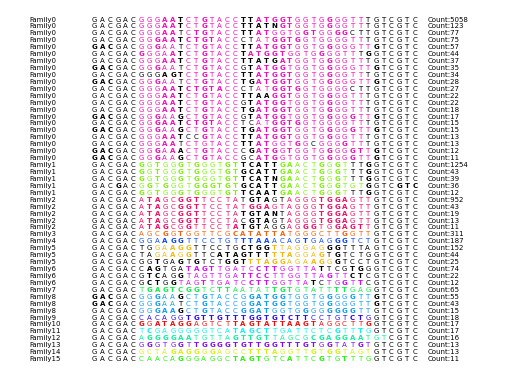

In [14]:
seq_sorted.drawText("../example/results/save.pdf", displaykmerfeature = 5, showLoop = True, featureminfrac = 0.8, header = "GACGAC", end = "GTCGTC")